# 📊 Projeto – PCA

Uma **empresa de fast-food** deseja abrir novas lojas ao redor do mundo  
e precisa apresentar de forma simples como os **países estão organizados**  
em termos de **variáveis ou indicadores macroeconômicos**  
(como inflação, arrecadação, expectativa de vida, dentre outros).

---

🎯 Para representar os países em um **gráfico de apenas 3 dimensões**,  
iremos construir um **algoritmo de redução de dimensionalidade**  
que **reduza a quantidade de variáveis**,  
permitindo assim a **visualização necessária para tomada de decisão** pela Diretoria.

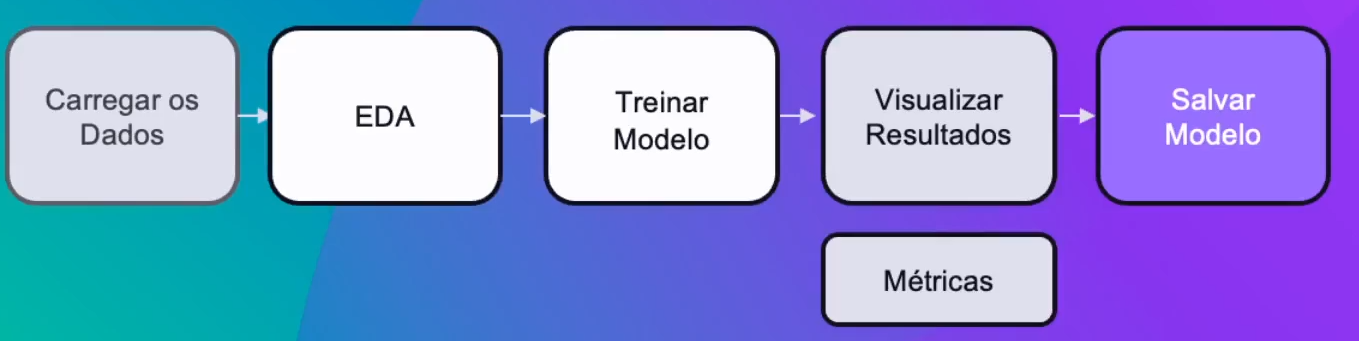

In [1]:
# EDA e visualizacao
import pandas as pd
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt

# ML
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import numpy as np

In [3]:
# carregar o dataframe
df_countries = pd.read_csv('./datasets/Country_Data.csv', sep=';', decimal=',')

In [4]:
# analisar a estrutura
df_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          165 non-null    object 
 1   child_mort       165 non-null    float64
 2   exports          165 non-null    float64
 3   health           165 non-null    float64
 4   imports          165 non-null    float64
 5   income           165 non-null    int64  
 6   inflation        165 non-null    float64
 7   life_expec       165 non-null    float64
 8   total_fer        165 non-null    float64
 9   gdpp             165 non-null    int64  
 10  income_category  165 non-null    object 
dtypes: float64(7), int64(2), object(2)
memory usage: 14.3+ KB


In [5]:
# visualizar os primeiros registros
df_countries.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,income_category
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553,Low income
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,Upper middle income
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,Lower middle income
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,Lower middle income
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,High income
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300,Upper middle income
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,Upper middle income
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,High income
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,High income
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840,Upper middle income


In [6]:
# visualizar os ultimos registros
df_countries.tail(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,income_category
155,Ukraine,11.7,47.1,7.72,51.1,7820,13.40,70.4,1.44,2970,Lower middle income
156,United Arab Emirates,8.6,77.7,3.66,63.6,57600,12.50,76.5,1.87,35000,High income
157,United Kingdom,5.2,28.2,9.64,30.8,36200,1.57,80.3,1.92,38900,High income
158,United States,7.3,12.4,17.90,15.8,49400,1.22,78.7,1.93,48400,High income
159,Uruguay,10.6,26.3,8.35,25.4,17100,4.91,76.4,2.08,11900,High income
160,Uzbekistan,36.3,31.7,5.81,28.5,4240,16.50,68.8,2.34,1380,Lower middle income
161,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,Lower middle income
162,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,Lower middle income
163,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,Low income
164,Zambia,83.1,37.0,5.89,30.9,3280,14.00,52.0,5.40,1460,Lower middle income


### EDA

### Análise Univariada

In [7]:
# estatisticas das variaveis
df_countries.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,38.567273,41.193327,6.825576,46.999793,17183.412121,7.585612,70.505455,2.959818,13011.963636
std,40.480851,27.560749,2.759425,24.233083,19389.968166,10.198185,8.935045,1.518166,18428.279743
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,7.900000,23.800000,4.930000,30.400000,3340.000000,1.770000,65.300000,1.800000,1310.000000
50%,19.700000,35.000000,6.320000,43.300000,9940.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.200000,51.400000,8.650000,58.900000,22900.000000,10.600000,76.800000,3.910000,14600.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [8]:
# distribuicao da variavel income_category
percentual_income_category = df_countries.value_counts('income_category') / len(df_countries) * 100
px.bar(percentual_income_category, color=percentual_income_category.index)

In [9]:
# distribuicao da variavel income
px.histogram(df_countries['income'], title='Histograma da variável income')

In [14]:
# distribuicao da variavel GDPP (PIB per capita)
px.histogram(df_countries['gdpp'], title='Histograma da variável GDPP')

In [ ]:
# distribuicao da variavel inflation
px.histogram(df_countries['inflation'], title='Histograma da variável Inflation')

In [17]:
# distribuicao da variavel life expectation
px.histogram(df_countries['life_expec'], title='Histograma da variável Life Expectation')

### Análise Bivariada

In [18]:
# plot de distribuicao (boxplot) por income e income_category
px.box(df_countries, x='income', y='income_category', color='income_category', orientation='h', hover_data=['country'])

In [20]:
# plot de distribuicao (boxplot) por gdpp e income_category
px.box(df_countries, x='gdpp', y='income_category', color='income_category', orientation='h', hover_data=['country'])

In [21]:
# plot de distribuicao (boxplot) por inflation e income_category
px.box(df_countries, x='inflation', y='income_category', color='income_category', orientation='h', hover_data=['country'])

In [22]:
# plot de distribuicao (boxplot) por life expec e income_category
px.box(df_countries, x='life_expec', y='income_category', color='income_category', orientation='h', hover_data=['country'])

In [23]:
# scatterplot de income e gdpp
px.scatter(df_countries, x='income', y='gdpp', color='income_category', hover_data='country')

In [27]:
# gerar matriz de correlacao
matriz_correlacao_coutries = df_countries.corr(numeric_only=True)

<Axes: >

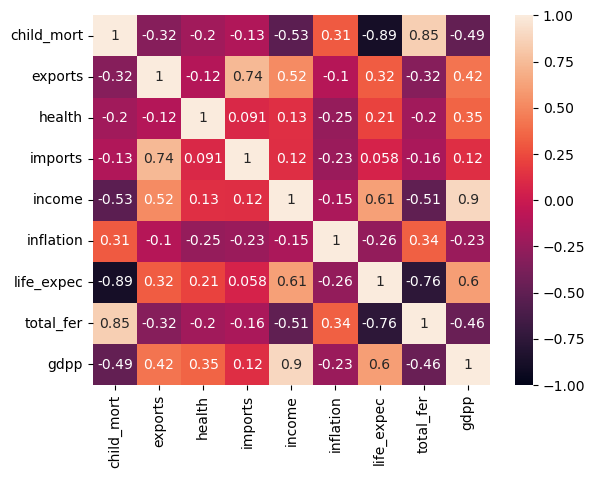

In [28]:
# plotar matriz de correlacao
sns.heatmap(matriz_correlacao_coutries, vmin=-1, vmax=1, annot=True)

### Treinar o algoritmo PCA

In [30]:
# selecionar as colunas para PCA
X = df_countries.copy()

# remover colunas desnecessarias
X.drop(columns=['country', 'income_category'], axis=1, inplace=True)

In [31]:
# separar variaveis quantitativas
numeric_features = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

In [32]:
# definir transformacoes
numeric_transformer = StandardScaler()

In [33]:
# criar pre processador de transformacoes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

In [34]:
# transformar os dados
X_transformed = preprocessor.fit_transform(X)

In [35]:
# visualizar X_transformed
X_transformed

array([[ 1.27936799, -1.13524796,  0.2742313 , ..., -1.6059239 ,
         1.88970656, -0.67813658],
       [-0.54431031, -0.48015711, -0.10017109, ...,  0.65049307,
        -0.86538974, -0.48561903],
       [-0.27918316, -0.10166017, -0.96529507, ...,  0.67294498,
        -0.04612849, -0.46548008],
       ...,
       [-0.37829611,  1.12117608,  0.00524318, ...,  0.29126251,
        -0.66718138, -0.63693336],
       [ 0.43938573, -0.40736924, -0.59816262, ..., -0.33739098,
         1.12990782, -0.63693336],
       [ 1.1034425 , -0.15261168, -0.34007942, ..., -2.07741401,
         1.61221484, -0.62876892]])

In [36]:
# matriz de covariancia
np.cov(X_transformed)

array([[ 1.28101845, -0.30929073, -0.13299078, ..., -0.31162981,
         0.6038062 ,  1.11986219],
       [-0.30929073,  0.19023088,  0.05718309, ...,  0.14855132,
        -0.14287309, -0.40453184],
       [-0.13299078,  0.05718309,  0.3368898 , ...,  0.03260987,
         0.28911912, -0.02412952],
       ...,
       [-0.31162981,  0.14855132,  0.03260987, ...,  0.5954005 ,
        -0.08211639, -0.23881978],
       [ 0.6038062 , -0.14287309,  0.28911912, ..., -0.08211639,
         0.71221987,  0.6856765 ],
       [ 1.11986219, -0.40453184, -0.02412952, ..., -0.23881978,
         0.6856765 ,  1.231984  ]])

In [37]:
# criar modelo pca
modelo_pca = PCA(n_components=3)

In [38]:
# executar pca
X_pca = modelo_pca.fit_transform(X_transformed)

In [39]:
# gerar um dataframe com base nos componentes principais
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

In [41]:
# visualizar componentes principais
df_pca.head(10)

,PC1,PC2,PC3
0,-2.898491,0.043830,-0.674704
1,0.435969,-0.602095,-0.336181
2,-0.294489,-0.393013,1.237849
3,-2.941128,1.746346,1.498419
4,1.038913,0.117437,-0.255625
5,0.005300,-1.713515,0.990698
6,-0.096950,-0.555750,0.231357
7,2.339830,-1.987538,0.349795
8,2.967046,-0.761415,-0.424208
9,-0.188400,-0.364424,0.896714


In [42]:
# verificar o tamanho do dataframe de pca
len(df_pca)

165

In [43]:
# incluir componentes principais no dataframe original
df_countries['PC1'] = df_pca['PC1']
df_countries['PC2'] = df_pca['PC2']
df_countries['PC3'] = df_pca['PC3']

In [44]:
# mostrar dataframe original com componentes principais
df_countries.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,income_category,PC1,PC2,PC3
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553,Low income,-2.898491,0.043830,-0.674704
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,Upper middle income,0.435969,-0.602095,-0.336181
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,Lower middle income,-0.294489,-0.393013,1.237849
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,Lower middle income,-2.941128,1.746346,1.498419
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,High income,1.038913,0.117437,-0.255625
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300,Upper middle income,0.005300,-1.713515,0.990698
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,Upper middle income,-0.096950,-0.555750,0.231357
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,High income,2.339830,-1.987538,0.349795
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,High income,2.967046,-0.761415,-0.424208
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840,Upper middle income,-0.188400,-0.364424,0.896714


### Visualizar Resultados

In [47]:
# autovalores
autovetores = modelo_pca.explained_variance_

# autovetores
autovalores = modelo_pca.components_

print('Autovetores:')
print(autovetores)
print('\nAutovalores:')
print(autovalores)

Autovetores:
[4.18194258 1.55676483 1.15683401]

Autovalores:
[[-0.41944537  0.28242091  0.15068193  0.16069962  0.39721431 -0.20064752
   0.42542863 -0.40370133  0.39213733]
 [ 0.18639458  0.61906392 -0.26537269  0.6623149   0.03301443  0.03814569
  -0.21355639  0.15172601 -0.04196516]
 [-0.02457745  0.11382205 -0.57151155 -0.33939771  0.32266099  0.63616571
   0.11811594  0.02417555  0.14584745]]


In [49]:
# mostrar chart 3d com os componentes principais
fig = px.scatter_3d(df_countries, x='PC1', y='PC2', z='PC3', color='income_category', 
                    title='Visualização PCA', width=800, height=600, hover_data=['country'])
fig.show()

In [50]:
# reconstruir os dados com base no pca
X_recovered = modelo_pca.inverse_transform(X_pca)

In [52]:
# visualizar recovered
X_recovered.shape[1]

9

In [53]:
# calcular o erro de reconstrucao
reconstruction_error = mean_squared_error(X_transformed, X_recovered)
print('Erro de Reconstrução:', reconstruction_error)

Erro de Reconstrução: 0.2384721934986097


### Salvar Modelo

In [54]:
import joblib

# Salvar Modelo
joblib.dump(modelo_pca, './modelo_pca_countries.pkl')

# Salvar Preprocessor
joblib.dump(preprocessor, './preprocessor_pca_countries.pkl')

['./preprocessor_pca_countries.pkl']